<a href="https://colab.research.google.com/github/RadimKozl/OpenCV_academy_my_work/blob/main/Keras_finetune_sports_vgg_kaggle_CZ.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://github.com/RadimKozl/OpenCV_academy_my_work/blob/img/OpenCV_logo.png?raw=1" alt="OpenCV logo" style="width: 200px;"/>

###### <font size="10">Lekce 22 - Jemné doladění klasifikátoru obrázků pomocí Google Colab</font>




## ***Transfer Learning a Jemné doladění (Fine-tuning)***

# ***Úvod***

## Obsah lekce

V této kapitole se naučíme, jak doladit předem natrénovaný model pro jiný úkol, než pro který byl původně natrénován.

Když trénujeme síť od začátku, narazíme na následující dvě omezení:

- ***Potřeba obrovského množství dat*** – Vzhledem k tomu, že síť má miliony parametrů, abychom získali optimální sadu parametrů, potřebujeme mít hodně dat.
- ***Potřeba obrovského výpočetní výkonu*** – I když máme hodně dat, školení obecně vyžaduje více iterací a vybírá si daň z výpočetních zdrojů.

Předtrénované modely jsou trénovány na problémech klasifikace obrázků ve velkém měřítku. Konvoluční vrstvy fungují jako extraktor prvků a plně spojené vrstvy fungují jako klasifikátory.

Vzhledem k tomu, že tyto modely jsou velmi velké a viděly obrovské množství obrázků, mají tendenci učit se velmi dobře, rozlišují vlastnosti. Můžeme buď použít konvoluční vrstvy pouze jako extraktor prvků a změnit poslední vrstvu podle našeho problému, nebo můžeme upravit již natrénované konvoluční vrstvy tak, aby vyhovovaly našemu problému. První přístup je známý jako ***Transfer Learning*** a druhý jako ***Fine-tuning***.

Úkolem doladění sítě je vyladit parametry již natrénované sítě tak, aby se přizpůsobila novému úkolu. Počáteční vrstvy sítě se učí velmi obecné rysy a jak postupujeme výše v síti, vrstvy mají tendenci učit se vzory specifičtější pro úkol, na který jsou trénovány. Pro doladění tedy chceme zachovat původní vrstvy nedotčené (nebo je zmrazit) a přeškolit pozdější vrstvy pro náš úkol.

Jemné doladění se tak vyhne oběma výše uvedeným omezením.

- Za prvé, netrénujeme celou síť. Za druhé, část, která je trénována, není trénována od nuly.
- Vzhledem k tomu, že parametrů, které je třeba aktualizovat, je méně, budeme také potřebovat kratší čas.

Zpravidla platí, že když máme malou tréninkovou sadu a náš problém je podobný úkolu, na který byly trénované předem trénované modely, můžeme použít přenosové učení (transfer learning). Pokud máme dostatek dat, můžeme se pokusit vyladit konvoluční vrstvy tak, aby se naučily robustnější funkce relevantní pro náš problém. [Zde](https://cs231n.github.io/transfer-learning/) můžete získat podrobný přehled o Fine-tuning a transfer learningu.

In [9]:
%tensorflow_version 2.x
import tensorflow as tf
print(tf.__version__)


import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
import os,shutil

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
2.15.0


In [10]:
# Install kaggle
!pip install kaggle


# ***Načtení datové sady z kaggle***

Jak načíst datové sady kaggle jsme již probrali v předchozí části. Budeme používat datovou sadu Sport odvozenou od kaggle datoveé sady [100 Sports Image Classification](https://www.kaggle.com/datasets/gpiosenka/sports-classification). Datová sada obsahuje 100 tříd sportů, je rozdělena do jednotlivých sad dat, ty jsme sloučili do jedné.

>POZNÁMKA: Ke stažení datové sady kaggle na colab budete muset použít svůj token API z kaggle ( soubor kaggle.json ). Pro provedení experimentu můžete datovou sadu také ručně nahrát na disk Google.

In [11]:
from google.colab import files
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(name=fn, length=len(uploaded[fn])))

# The Kaggle API client expects this file to be in ~/.kaggle,
# so move it there.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d radimkzl/sports

# Unzip all files and suppress output
!unzip -q sports.zip

Saving kaggle.json to kaggle (1).json
User uploaded file "kaggle (1).json" with length 64 bytes
Dataset URL: https://www.kaggle.com/datasets/radimkzl/sports
License(s): unknown
sports.zip: Skipping, found more recently modified local copy (use --force to force download)


In [12]:
# !cat ~/.kaggle/kaggle.json

In [13]:
# This folder contians all the class folders
main_path = 'Sports/'
print(main_path)

Sports/


In [14]:
# all class names
classnames = os.listdir(main_path)
print(classnames)

['motorcycle racing', 'steer wrestling', 'lacrosse', 'swimming', 'bobsled', 'track bicycle', 'canoe slamon', 'figure skating men', 'basketball', 'judo', 'baton twirling', 'boxing', 'snowmobile racing', 'wheelchair basketball', 'rollerblade racing', 'axe throwing', 'weightlifting', 'cheerleading', 'tennis', 'volleyball', 'water polo', 'high jump', 'balance beam', 'formula 1 racing', 'ampute football', 'football', 'horse jumping', 'hydroplane racing', 'frisbee', 'parallel bar', 'curling', 'table tennis', 'sidecar racing', 'nascar racing', 'pole dancing', 'log rolling', 'polo', 'luge', 'air hockey', 'sky surfing', 'cricket', 'baseball', 'billiards', 'speed skating', 'rugby', 'arm wrestling', 'ski jumping', 'rowing', 'mushing', 'sumo wrestling', 'figure skating women', 'skydiving', 'figure skating pairs', 'pole vault', 'horseshoe pitching', 'golf', 'jousting', 'uneven bars', 'bowling', 'croquet', 'ultimate', 'ice yachting', 'hammer throw', 'snow boarding', 'chuckwagon racing', 'bike polo',

In [15]:
# See how many images you have per class, this helps you set the required percentage of validation data.
for each_class in classnames:
  print("Class: {}, has {} samples".format( each_class,len(os.listdir(os.path.join(main_path,each_class )))))

Class: motorcycle racing, has 142 samples
Class: steer wrestling, has 132 samples
Class: lacrosse, has 161 samples
Class: swimming, has 167 samples
Class: bobsled, has 148 samples
Class: track bicycle, has 145 samples
Class: canoe slamon, has 174 samples
Class: figure skating men, has 138 samples
Class: basketball, has 179 samples
Class: judo, has 160 samples
Class: baton twirling, has 118 samples
Class: boxing, has 126 samples
Class: snowmobile racing, has 157 samples
Class: wheelchair basketball, has 116 samples
Class: rollerblade racing, has 169 samples
Class: axe throwing, has 123 samples
Class: weightlifting, has 144 samples
Class: cheerleading, has 141 samples
Class: tennis, has 141 samples
Class: volleyball, has 152 samples
Class: water polo, has 140 samples
Class: high jump, has 168 samples
Class: balance beam, has 157 samples
Class: formula 1 racing, has 200 samples
Class: ampute football, has 122 samples
Class: football, has 201 samples
Class: horse jumping, has 144 samples
C

# ***Uspořádejme si data***

Již jsme si vysvětlili v předchozí části, jak by měla být data uspořádána, aby byla předána do tréninkového kanálu v Kerasu.

Zde budeme data úhledně umístit do složek *train* a *validation* uvnitř hlavní složky s názvem 'fruits' (změňte název, pokud chcete), můžete nastavit procento sady *validation*. Nastavili jsme to na 15 %. Takže 15 % obrázků z každé třídy půjde do složky *validation* a zbytek do složky *train*.

In [16]:
#!rm -r fruits

base_dir= 'sports'

total_train_images = 0
total_val_images = 0

os.mkdir(base_dir)

train_dir = os.path.join(base_dir, 'train')
os.mkdir(train_dir)

validation_dir = os.path.join(base_dir, 'validation')
os.mkdir(validation_dir)

# Set the percent of validation data you want.
validation_percent = 15

for each_class in classnames:

  source_directory = os.path.join(main_path,each_class )
  destination_train_directory = os.path.join(train_dir,each_class)
  destination_validation_directory = os.path.join(validation_dir,each_class)


  total_image_count = len(os.listdir(source_directory))

  valid_image_count = int(np.floor(total_image_count * (validation_percent/100)))

  train_images_count = int( total_image_count - valid_image_count )

  total_train_images +=  train_images_count
  total_val_images += valid_image_count

  os.mkdir(destination_train_directory)
  os.mkdir(destination_validation_directory)

  # copying the data to class's train folder
  file_names = os.listdir(source_directory)[:train_images_count]

  for fname in file_names:
      src = os.path.join(source_directory, fname)
      dst = os.path.join(destination_train_directory, fname)
      shutil.copyfile(src, dst)


  # Copying the data to class's validation folder
  file_names = os.listdir(source_directory)[train_images_count:]

  for fname in file_names:
      src = os.path.join(source_directory, fname)
      dst = os.path.join(destination_validation_directory, fname)
      shutil.copyfile(src, dst)

  print('total training {} images: {}'.format(each_class, len(os.listdir(destination_train_directory))))
  print('total validation {} images: {}'.format(each_class, len(os.listdir(destination_validation_directory))))

total training motorcycle racing images: 121
total validation motorcycle racing images: 21
total training steer wrestling images: 113
total validation steer wrestling images: 19
total training lacrosse images: 137
total validation lacrosse images: 24
total training swimming images: 142
total validation swimming images: 25
total training bobsled images: 126
total validation bobsled images: 22
total training track bicycle images: 124
total validation track bicycle images: 21
total training canoe slamon images: 148
total validation canoe slamon images: 26
total training figure skating men images: 118
total validation figure skating men images: 20
total training basketball images: 153
total validation basketball images: 26
total training judo images: 136
total validation judo images: 24
total training baton twirling images: 101
total validation baton twirling images: 17
total training boxing images: 108
total validation boxing images: 18
total training snowmobile racing images: 134
total v

# ***Zmrazte požadované vrstvy***

V Keras má každá vrstva parametr nazvaný ***“trainable”***. Pro zmrazení vah konkrétní vrstvy bychom měli nastavit tento parametr na ***False***, což znamená, že tato vrstva by neměla být trénována. A je to! Procházíme každou vrstvu a vybíráme, které vrstvy chceme trénovat.

```python
# Freeze the layers except the last 4 layers
for layer in EfficientNetB0_conv.layers[:-4]:
    layer.trainable = False
```

# ***Experiment 1: Zmrazení všech vrstev – Stejné jako Transfer Learning***

In [18]:
from tensorflow.keras.applications import EfficientNetB0, mobilenet

image_size = 224

from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers

In [19]:
#Load the VGG model
EfficientNetB0_conv = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))
#include_topはFully Connected Layerはロードしないという意味

# Freeze all the layers
for layer in EfficientNetB0_conv.layers[:]:
    layer.trainable = False

# Check the trainable status of the individual layers
for layer in EfficientNetB0_conv.layers:
    print(layer, layer.trainable)



# Create the model
model = models.Sequential()

# Add the vgg convolutional base model
model.add(EfficientNetB0_conv)

# Add new layers
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(len(classnames), activation='softmax'))

# Show a summary of the model. Check the number of trainable parameters
model.summary()

16705208/16705208 [==============================] - 1s 0us/step
<keras.src.engine.input_layer.InputLayer object at 0x7f69148b1bd0> False
<keras.src.layers.preprocessing.image_preprocessing.Rescaling object at 0x7f6916d96e30> False
<keras.src.layers.preprocessing.normalization.Normalization object at 0x7f6916d94610> False
<keras.src.layers.preprocessing.image_preprocessing.Rescaling object at 0x7f6916d948b0> False
<keras.src.layers.reshaping.zero_padding2d.ZeroPadding2D object at 0x7f6916d94730> False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7f6916d94b20> False
<keras.src.layers.normalization.batch_normalization.BatchNormalization object at 0x7f6916d97a30> False
<keras.src.layers.core.activation.Activation object at 0x7f6916d97460> False
<keras.src.layers.convolutional.depthwise_conv2d.DepthwiseConv2D object at 0x7f691483d6f0> False
<keras.src.layers.normalization.batch_normalization.BatchNormalization object at 0x7f691483ca00> False
<keras.src.layers.core.activation.A

## ***Nastavte generátory dat***

Data jsme již rozdělili na trénovací a validační a uchovávali je ve složkách *„train“* a *„validation“*. Můžeme použít ***ImageDataGenerator*** dostupný v Kerasu ke čtení obrázků v dávkách přímo z těchto složek a volitelně provádět augmentaci dat. Použijeme dva různé generátory dat pro trénovací a validační složky.

In [20]:
# No Data augmentation
train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)

# Change the batchsize according to your system RAM
train_batchsize = 20
val_batchsize = 20

# Data Generator for Training data
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(image_size, image_size),
        batch_size=train_batchsize,
        class_mode='categorical')

# Data Generator for Validation data
validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(image_size, image_size),
        batch_size=val_batchsize,
        class_mode='categorical',
        shuffle=False)

Found 12362 images belonging to 100 classes.
Found 2129 images belonging to 100 classes.


## ***Trénujte model***

Doposud jsme vytvořili model a nastavili data pro trénování. Takže bychom měli pokračovat v tréninku a zkontrolovat výkon modelu. Budeme muset určit *optimalizátor* a *rychlost učení* a začít trénovat pomocí funkce ***model.fit()***. Po skončení tréningu model uložíme.

In [21]:
%%time
# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=1e-4),
              metrics=['acc'])

# Train the Model
history = model.fit(
      train_generator,
      steps_per_epoch=train_generator.samples/train_generator.batch_size ,
      epochs=20,
      validation_data=validation_generator,
      validation_steps=validation_generator.samples/validation_generator.batch_size,
      verbose=1)

Epoch 1/20


KeyboardInterrupt: 

## ***Uložte model***

Modely Keras jsou uloženy ve formátu ***h5***. Můžete použít pouze metodu uložení spolu s názvem požadovaného souboru.

In [ ]:
# Save the Model
model.save('all_freezed.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# If you want to download your Model run this, you can also download it from the files tab on the left
from google.colab import files
files.download('all_freezed.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## ***Zkontrolujte výkon***

Podívejme se na křivky ztrát a přesnosti.

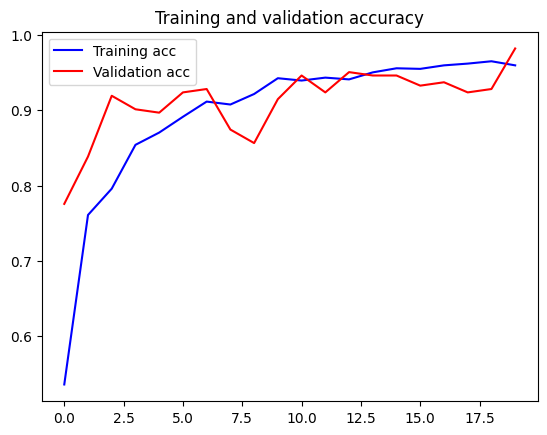

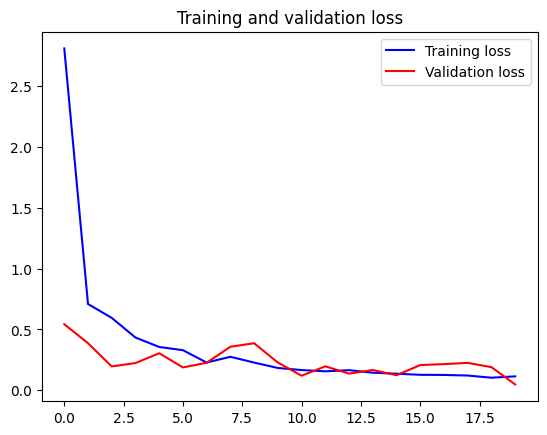

In [ ]:
# Plot the accuracy and loss curves
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## ***Ukažte chyby***

Také se podívejme vizuálně na chyby, které jsme dostali.

Found 223 images belonging to 6 classes.
11/11 [==============================] - 2s 145ms/step
No of errors = 4/223


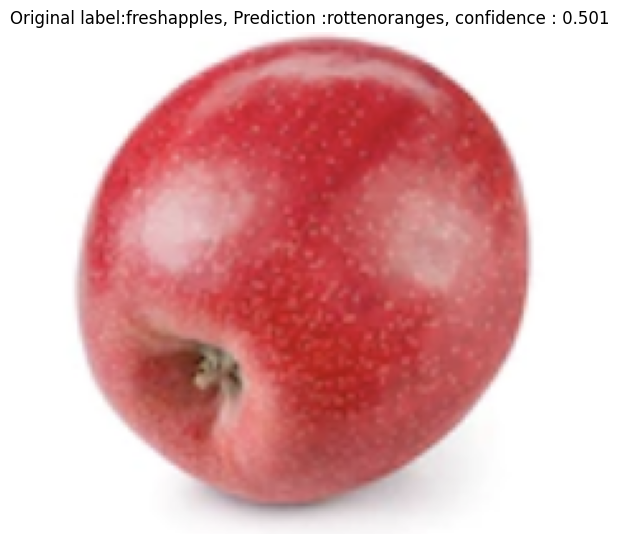

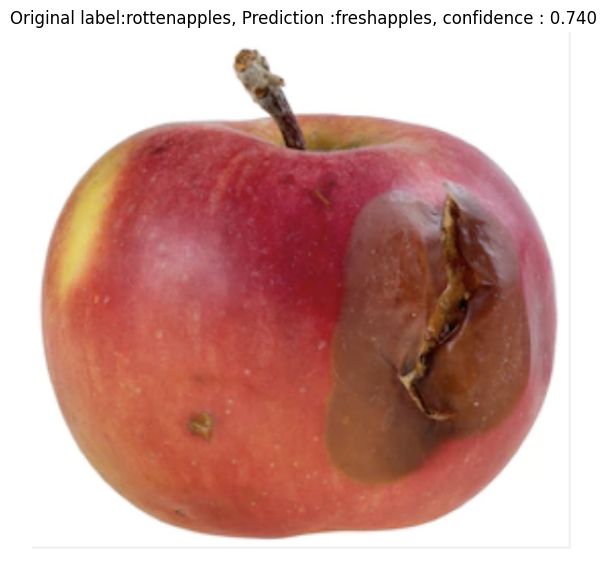

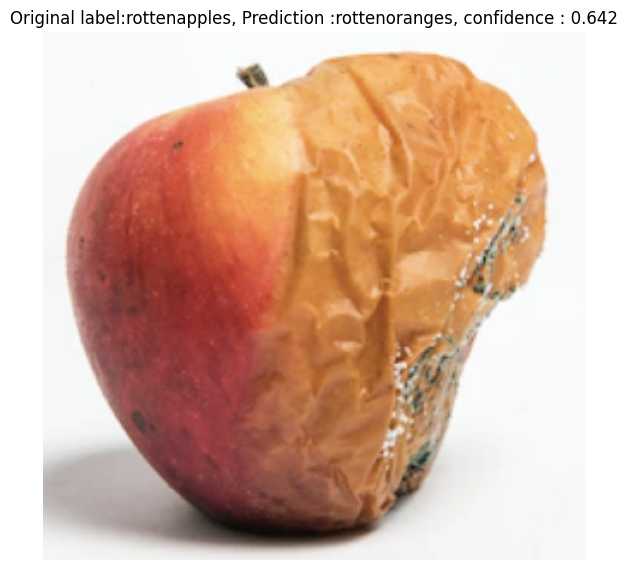

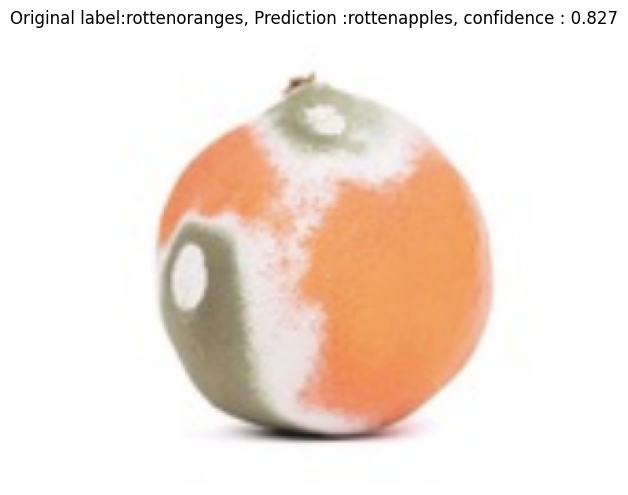

In [ ]:
# Create a generator for prediction
validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(image_size, image_size),
        batch_size=val_batchsize,
        class_mode='categorical',
        shuffle=False)

# Get the filenames from the generator
fnames = validation_generator.filenames

# Get the ground truth from generator
ground_truth = validation_generator.classes

# Get the label to class mapping from the generator
label2index = validation_generator.class_indices

# Getting the mapping from class index to class label
idx2label = dict((v,k) for k,v in label2index.items())

# Get the predictions from the model using the generator
predictions = model.predict(validation_generator, steps=validation_generator.samples/validation_generator.batch_size,verbose=1)
predicted_classes = np.argmax(predictions,axis=1)

errors = np.where(predicted_classes != ground_truth)[0]
print("No of errors = {}/{}".format(len(errors),validation_generator.samples))

# Show the errors
for i in range(len(errors)):
    pred_class = np.argmax(predictions[errors[i]])
    pred_label = idx2label[pred_class]

    title = 'Original label:{}, Prediction :{}, confidence : {:.3f}'.format(
        fnames[errors[i]].split('/')[0],
        pred_label,
        predictions[errors[i]][pred_class])

    original = load_img('{}/{}'.format(validation_dir,fnames[errors[i]]))
    plt.figure(figsize=[7,7])
    plt.axis('off')
    plt.title(title)
    plt.imshow(original)
    plt.show()

## ***Vyhodnocení***

Vidíme, že ztráta testu nekonverguje, i když tréninková ztráta stále klesá. Zkusme natrénovat další vrstvy (Jemné doladění)

# ***Experiment 2: Trénujte poslední 4 vrstvy bez rozšíření dat***

V tomto experimentu ponecháme počáteční vrstvy zafixované a pouze přetrénujeme poslední 4 vrstvy. Vzhledem k tomu, že počáteční vrstvy se učí obecnější funkce, je dobrým zvykem zmrazit počáteční vrstvy a zároveň doladit poslední vrstvy sítě pro nový úkol.


In [ ]:
#Load the VGG model
EfficientNetB0_conv = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))

# Freeze all layers except the last 4
for layer in EfficientNetB0_conv.layers[:-4]:
    layer.trainable = False

# Check the trainable status of the individual layers
for layer in EfficientNetB0_conv.layers:
    print(layer, layer.trainable)

# Create the model
model = models.Sequential()

# Add the vgg convolutional base model
model.add(EfficientNetB0_conv)

# Add new layers
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(len(classnames), activation='softmax'))

# Show a summary of the model. Check the number of trainable parameters
model.summary()

<keras.src.engine.input_layer.InputLayer object at 0x795fb0161e10> False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x795fb0184ca0> False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x795fa970a9b0> False
<keras.src.layers.pooling.max_pooling2d.MaxPooling2D object at 0x795fb012e710> False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x795fb0187880> False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x795fb012f220> False
<keras.src.layers.pooling.max_pooling2d.MaxPooling2D object at 0x795fb012fd30> False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x79601f70a530> False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x795fb012f6a0> False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x795fb012f850> False
<keras.src.layers.pooling.max_pooling2d.MaxPooling2D object at 0x795fa9783250> False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x795fb012e110> False
<keras.src.layers.convolutional.conv2d.Conv2D ob

## ***Trénujte model***

In [ ]:
# No Data augmentation
train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)

# Change the batchsize according to your system RAM
train_batchsize = 50
val_batchsize = 20

# Data Generator for Training data
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(image_size, image_size),
        batch_size=train_batchsize,
        class_mode='categorical')

# Data Generator for Validation data
validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(image_size, image_size),
        batch_size=val_batchsize,
        class_mode='categorical',
        shuffle=False)

# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=1e-4),
              metrics=['acc'])

# Train the Model
history = model.fit(
      train_generator,
      steps_per_epoch=train_generator.samples/train_generator.batch_size ,
      epochs=20,
      validation_data=validation_generator,
      validation_steps=validation_generator.samples/validation_generator.batch_size,
      verbose=1)

Found 1289 images belonging to 6 classes.
Found 223 images belonging to 6 classes.
Epoch 1/20
25/25 [==============================] - 30s 743ms/step - loss: 1.0984 - acc: 0.5974 - val_loss: 0.3268 - val_acc: 0.8879
Epoch 2/20
25/25 [==============================] - 11s 428ms/step - loss: 0.3680 - acc: 0.8681 - val_loss: 0.2774 - val_acc: 0.8969
Epoch 3/20
25/25 [==============================] - 11s 425ms/step - loss: 0.2129 - acc: 0.9240 - val_loss: 0.1818 - val_acc: 0.9148
Epoch 4/20
25/25 [==============================] - 11s 427ms/step - loss: 0.1408 - acc: 0.9535 - val_loss: 0.1634 - val_acc: 0.9552
Epoch 5/20
25/25 [==============================] - 11s 427ms/step - loss: 0.0782 - acc: 0.9752 - val_loss: 0.4492 - val_acc: 0.8700
Epoch 6/20
25/25 [==============================] - 10s 397ms/step - loss: 0.2522 - acc: 0.9527 - val_loss: 0.1139 - val_acc: 0.9507
Epoch 7/20
25/25 [==============================] - 12s 472ms/step - loss: 0.0501 - acc: 0.9868 - val_loss: 0.1327 - va

In [ ]:
# Save the Model
model.save('last4_layers.h5')

# you can also download the model to your pc from the files tab on the left

In [ ]:
#from google.colab import files
files.download('last4_layers.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

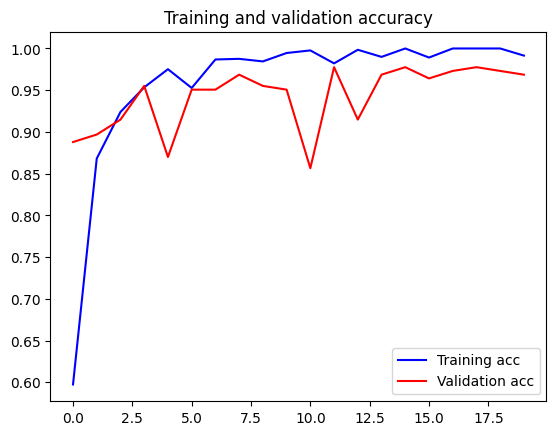

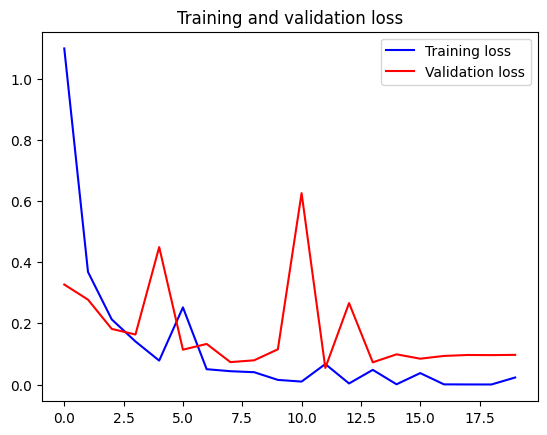

In [ ]:
# Plot the accuracy and loss curves
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## ***Ukažte chyby***

Found 223 images belonging to 6 classes.
11/11 [==============================] - 2s 140ms/step
No of errors = 7/223


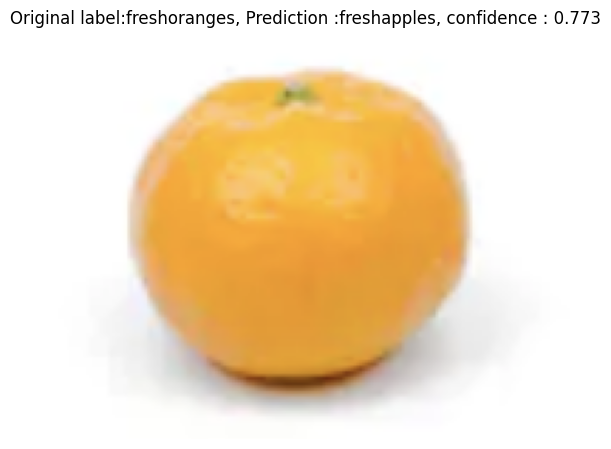

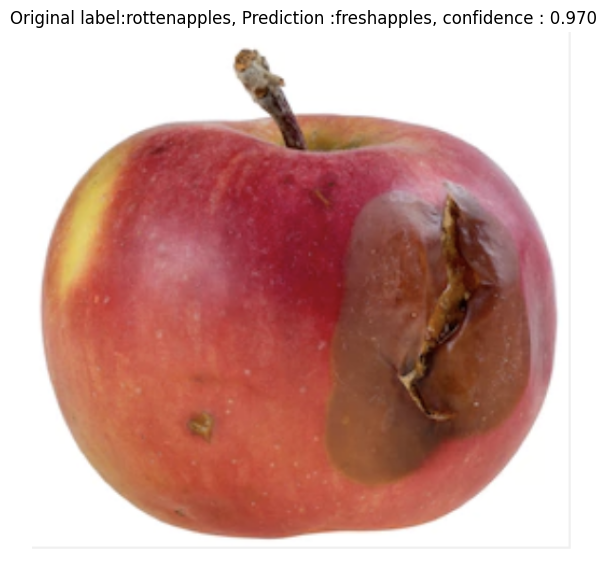

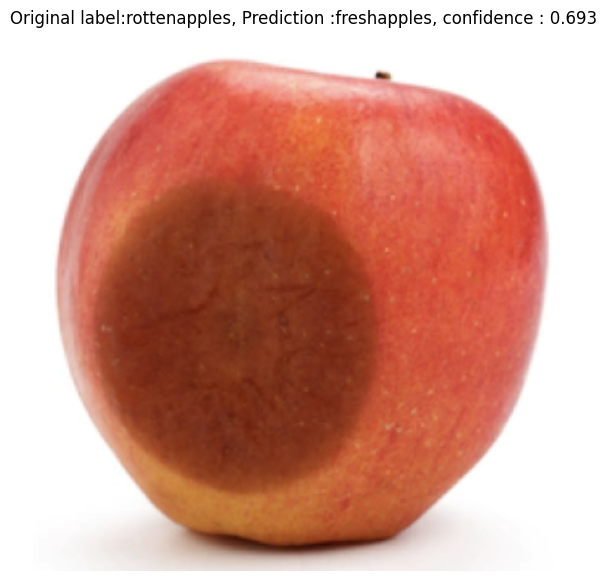

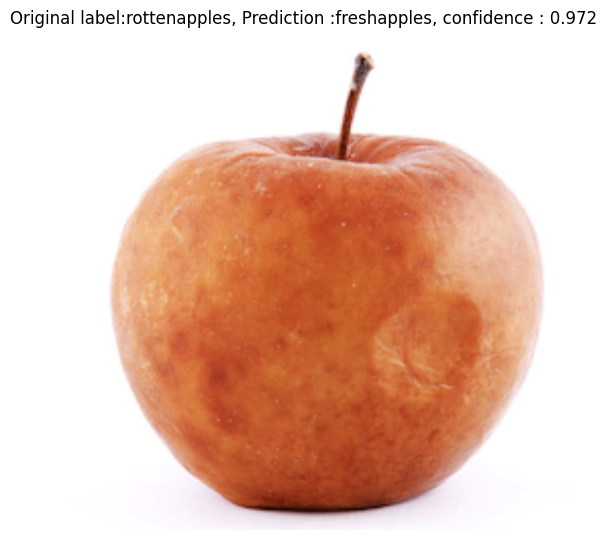

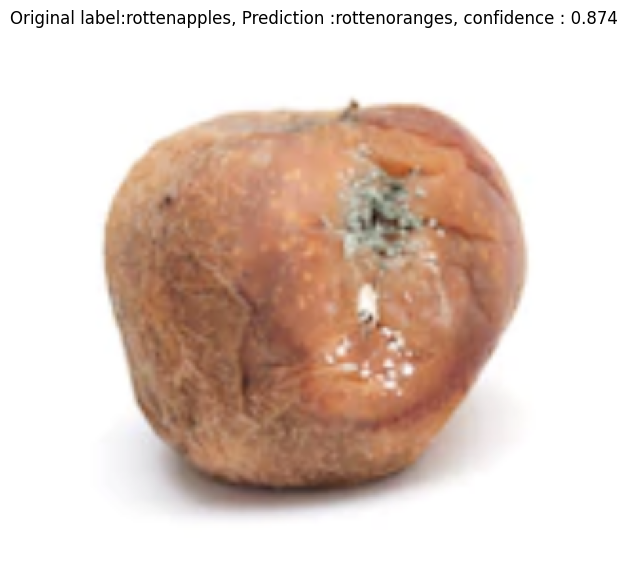

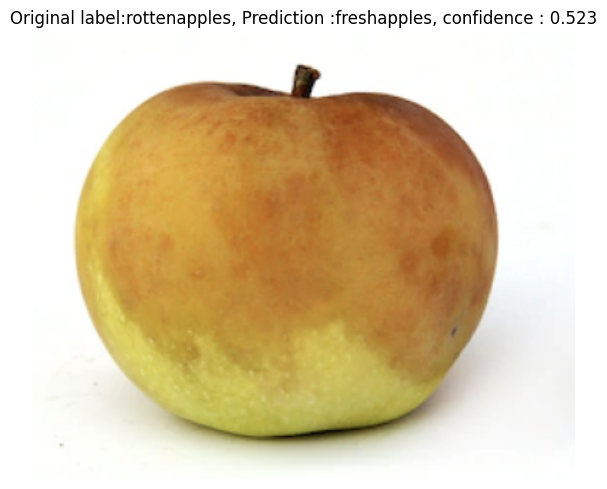

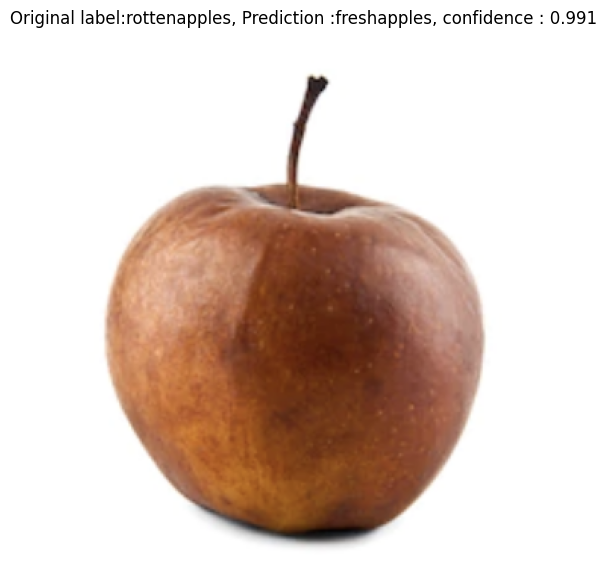

In [ ]:
# Create a generator for prediction
validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(image_size, image_size),
        batch_size=val_batchsize,
        class_mode='categorical',
        shuffle=False)

# Get the filenames from the generator
fnames = validation_generator.filenames

# Get the ground truth from generator
ground_truth = validation_generator.classes

# Get the label to class mapping from the generator
label2index = validation_generator.class_indices

# Getting the mapping from class index to class label
idx2label = dict((v,k) for k,v in label2index.items())

# Get the predictions from the model using the generator
predictions = model.predict(validation_generator, steps=validation_generator.samples/validation_generator.batch_size,verbose=1)
predicted_classes = np.argmax(predictions,axis=1)

errors = np.where(predicted_classes != ground_truth)[0]
print("No of errors = {}/{}".format(len(errors),validation_generator.samples))

# Show the errors
for i in range(len(errors)):
    pred_class = np.argmax(predictions[errors[i]])
    pred_label = idx2label[pred_class]

    title = 'Original label:{}, Prediction :{}, confidence : {:.3f}'.format(
        fnames[errors[i]].split('/')[0],
        pred_label,
        predictions[errors[i]][pred_class])

    original = load_img('{}/{}'.format(validation_dir,fnames[errors[i]]))
    plt.figure(figsize=[7,7])
    plt.axis('off')
    plt.title(title)
    plt.imshow(original)
    plt.show()

# ***Experiment 3: Trénujte posledních 8 vrstev pomocí rozšíření dat***

Tento experiment provádíme, abychom si ověřili, zda můžeme získat ještě lepší výsledky než předchozí experiment. Trénujeme více vrstev a také využíváme augmentaci dat při tréninku.

In [ ]:
#Load the VGG model
EfficientNetB0_conv = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))

# Freeze all the layers
for layer in EfficientNetB0_conv.layers[:-8]:
    layer.trainable = False

# Check the trainable status of the individual layers
for layer in EfficientNetB0_conv.layers:
    print(layer, layer.trainable)

# Create the model
model = models.Sequential()

# Add the vgg convolutional base model
model.add(EfficientNetB0_conv)

# Add new layers
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(len(classnames), activation='softmax'))

# Show a summary of the model. Check the number of trainable parameters
model.summary()

<keras.src.engine.input_layer.InputLayer object at 0x795fca1a4820> False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x795fa9783430> False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x795fa9790c10> False
<keras.src.layers.pooling.max_pooling2d.MaxPooling2D object at 0x795fa9491090> False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x795fa970be20> False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x795fa9493fd0> False
<keras.src.layers.pooling.max_pooling2d.MaxPooling2D object at 0x795fa9491f00> False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x795fa94933d0> False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x795fa972fa30> False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x795fa9418fa0> False
<keras.src.layers.pooling.max_pooling2d.MaxPooling2D object at 0x795fa94ad6f0> False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x795fa94aece0> True
<keras.src.layers.convolutional.conv2d.Conv2D obj

## ***Trénujte model***

Zde budeme pro rozšiřování dat používat imageDataGenerator.

In [ ]:
train_datagen = ImageDataGenerator(
      rescale=1./255,
      #rotation_range=20,
      #width_shift_range=0.2,
      #height_shift_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

validation_datagen = ImageDataGenerator(rescale=1./255)

# Change the batchsize according to your system RAM
train_batchsize = 20
val_batchsize = 20

# Data Generator for Training data
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(image_size, image_size),
        batch_size=train_batchsize,
        class_mode='categorical')

# Data Generator for Validation data
validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(image_size, image_size),
        batch_size=val_batchsize,
        class_mode='categorical',
        shuffle=False)

# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=1e-4),
              metrics=['acc'])

# Train the Model
# NOTE that we have multiplied the steps_per_epoch by 2. This is because we are using data augmentation.
history = model.fit(
      train_generator,
      steps_per_epoch=train_generator.samples/train_generator.batch_size ,
      epochs=20,
      validation_data=validation_generator,
      validation_steps=validation_generator.samples/validation_generator.batch_size,
      verbose=1)

Found 1289 images belonging to 6 classes.
Found 223 images belonging to 6 classes.
Epoch 1/20
25/25 [==============================] - 33s 1s/step - loss: 1.8515 - acc: 0.2281 - val_loss: 2.0318 - val_acc: 0.2018
Epoch 2/20
25/25 [==============================] - 25s 985ms/step - loss: 1.5643 - acc: 0.3413 - val_loss: 1.1255 - val_acc: 0.5964
Epoch 3/20
25/25 [==============================] - 26s 984ms/step - loss: 1.3019 - acc: 0.4725 - val_loss: 0.8979 - val_acc: 0.6816
Epoch 4/20
25/25 [==============================] - 26s 1s/step - loss: 1.0606 - acc: 0.6214 - val_loss: 0.7920 - val_acc: 0.6906
Epoch 5/20
25/25 [==============================] - 26s 1s/step - loss: 0.7858 - acc: 0.7161 - val_loss: 0.5379 - val_acc: 0.8027
Epoch 6/20
25/25 [==============================] - 26s 991ms/step - loss: 0.7051 - acc: 0.7517 - val_loss: 0.5092 - val_acc: 0.8117
Epoch 7/20
25/25 [==============================] - 26s 994ms/step - loss: 0.5241 - acc: 0.8185 - val_loss: 0.2561 - val_acc: 0.

In [ ]:
# Save the Model
model.save('da_last8_layers.h5')

# You can also download it from the files tab on the left

In [ ]:
#from google.colab import files
files.download('da_last8_layers.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

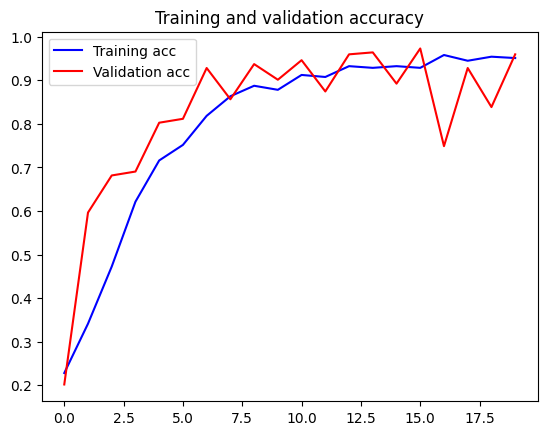

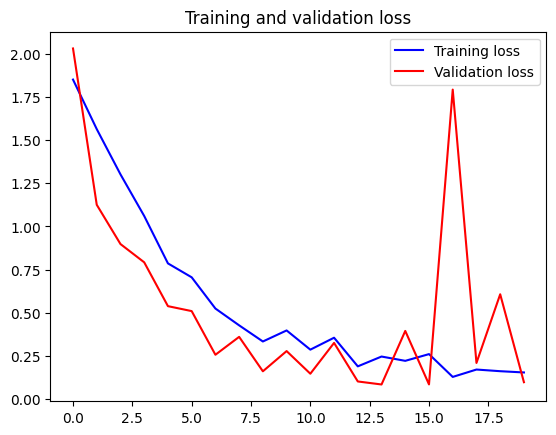

In [ ]:
# Plot the accuracy and loss curves
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## ***Ukažte chyby***

Found 223 images belonging to 6 classes.
11/11 [==============================] - 2s 177ms/step
No of errors = 9/223


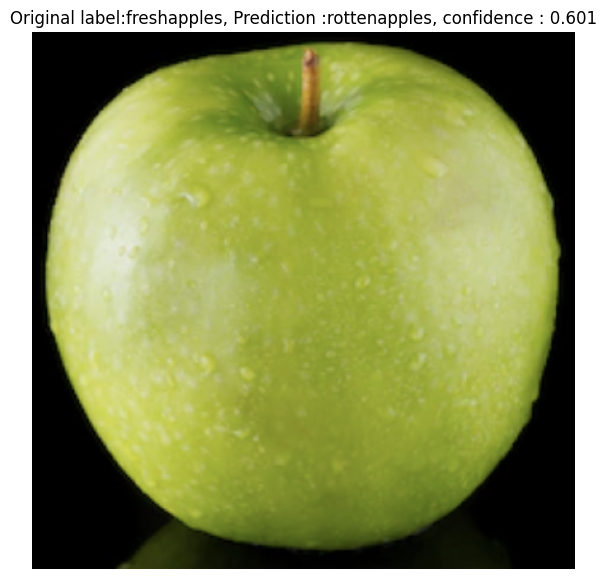

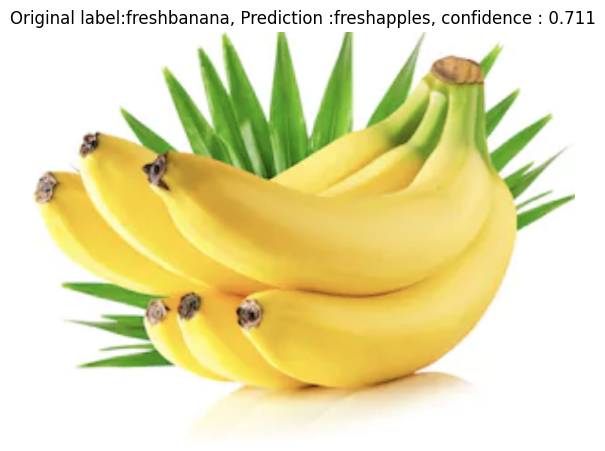

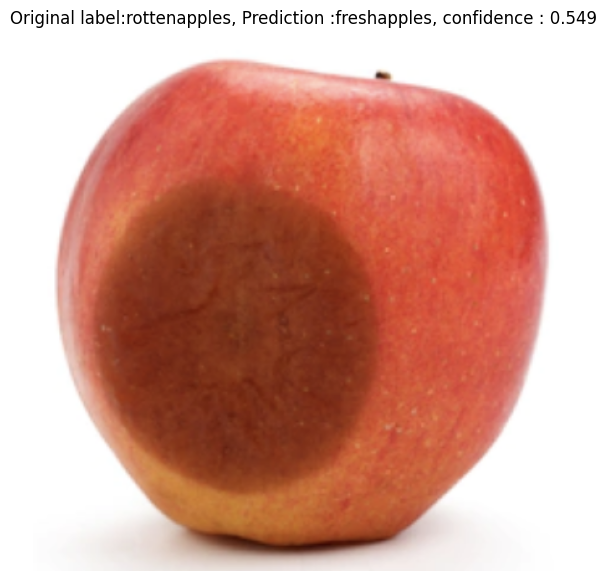

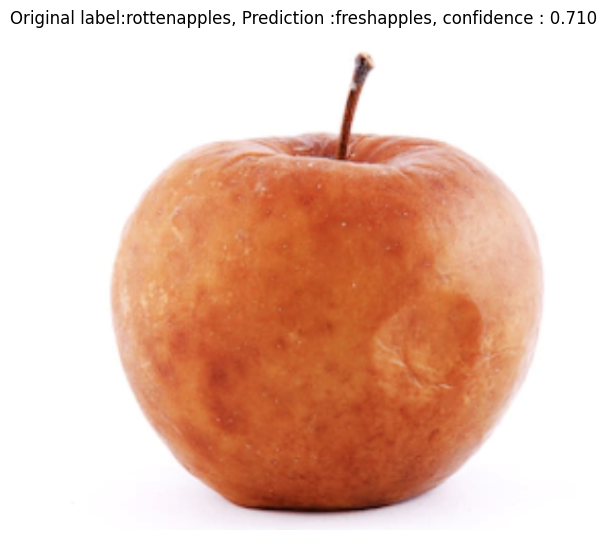

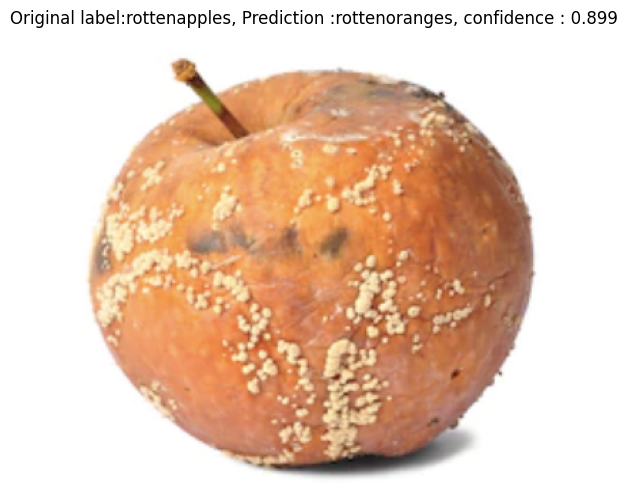

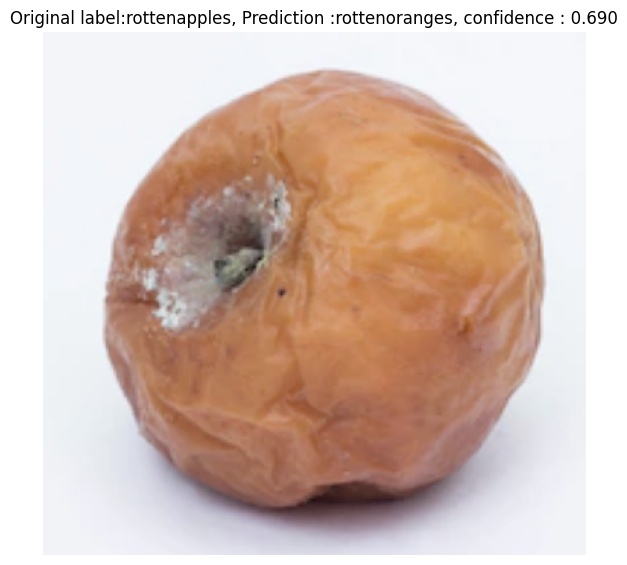

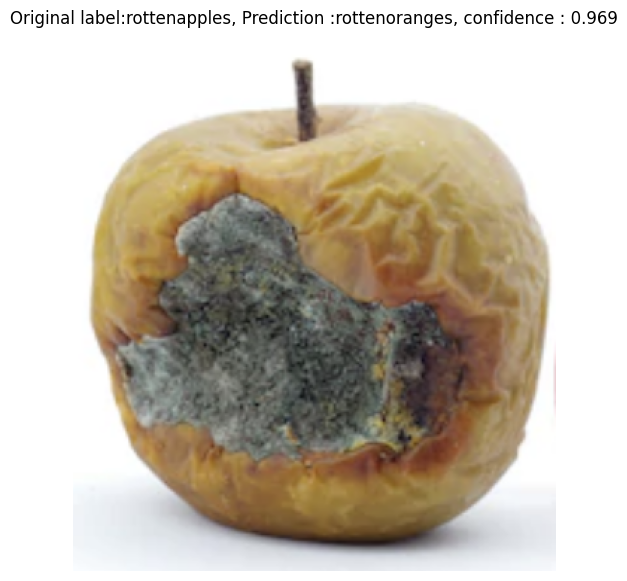

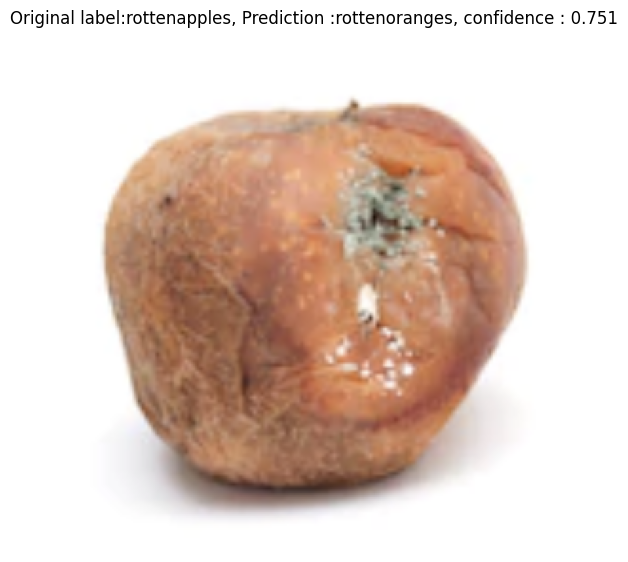

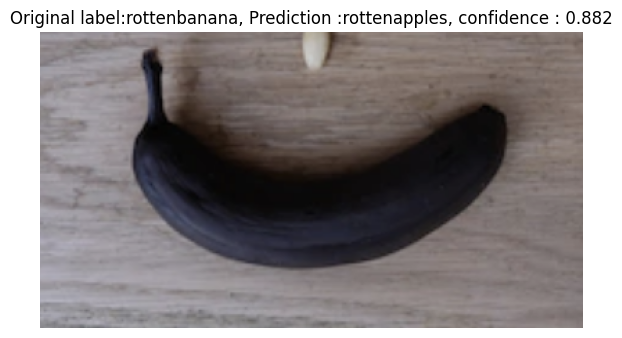

In [ ]:
# Create a generator for prediction
validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(image_size, image_size),
        batch_size=val_batchsize,
        class_mode='categorical',
        shuffle=False)

# Get the filenames from the generator
fnames = validation_generator.filenames

# Get the ground truth from generator
ground_truth = validation_generator.classes

# Get the label to class mapping from the generator
label2index = validation_generator.class_indices

# Getting the mapping from class index to class label
idx2label = dict((v,k) for k,v in label2index.items())

# Get the predictions from the model using the generator
predictions = model.predict(validation_generator, steps=validation_generator.samples/validation_generator.batch_size,verbose=1)
predicted_classes = np.argmax(predictions,axis=1)

errors = np.where(predicted_classes != ground_truth)[0]
print("No of errors = {}/{}".format(len(errors),validation_generator.samples))

# Show the errors
for i in range(len(errors)):
    pred_class = np.argmax(predictions[errors[i]])
    pred_label = idx2label[pred_class]

    title = 'Original label:{}, Prediction :{}, confidence : {:.3f}'.format(
        fnames[errors[i]].split('/')[0],
        pred_label,
        predictions[errors[i]][pred_class])

    original = load_img('{}/{}'.format(validation_dir,fnames[errors[i]]))
    plt.figure(figsize=[7,7])
    plt.axis('off')
    plt.title(title)
    plt.imshow(original)
    plt.show()

## ***Vyhodnocení***

V experimentu 2 se objevily známky nadměrného vybavení, které jsou do určité míry redukovány použitím augmentace dat. Měli byste zkusit spustit více epoch, abyste viděli účinek augmentace dat.

# ***Cvičení***

 - Zkuste použít jinou datovou sadu a zjistěte, zda stejný kód a síť funguje pro novou datovou sadu.
 - Zkuste rozmrazit více vrstev a uvidíte, jak se přesnost zlepší.
 - Zkuste jiný model místo VGG

# ***Reference a další materiály***

[Fine tuning](https://www.youtube.com/watch?v=WpzT9SDczfI)

[Apples Bananas Oranges](https://www.kaggle.com/datasets/sriramr/apples-bananas-oranges)